In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy
import scipy
from scipy import stats
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

C:\Users\xuyu1\Miniconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


载入数据，并将其转换为tensor格式便于随后输入神经网络进行运算。

In [2]:
fr = h5py.File('../data/train_data_1.h5', 'r')
data = fr['data']
label = fr['label']

In [3]:
x = torch.from_numpy(data[:].reshape(-1,1,1029)).float()
y = torch.from_numpy(label[:]).float()

In [4]:
fr.close()

In [5]:
train_dataset = TensorDataset(x[:1200000], y[:1200000])
valid_dataset = TensorDataset(x[1200000:], y[1200000:])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

下图显示了神经网络的输入与输出。输入为波形， 输出为击中时间在时间窗口内的分布。FADC波形的峰可视为一个或数个单值与单峰的耦合，

因此波形重建的实质是求解单峰的逆。由于求得解析解比较复杂，对数学的要求比较高，因而我使用神经网络作为工具力图求得某种形式的数值解。

此外为了求解计算的方便我将击中时间向后移动了7个单位以使其落在脉冲的峰的附近。

该事例的击中时间为: [287 303 310 319 355]
该事例每个时间的击中电荷数为: [1. 1. 2. 1. 1.]


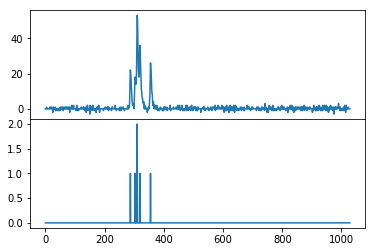

In [131]:
idx = 1604
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0})
ax1.plot(x[idx][0].numpy())
idx_n = np.where(y[idx].numpy()>0)[0]
ax2.plot(y[idx].numpy())
print('该事例的击中时间为:', idx_n)
print('该事例每个时间的击中电荷数为:', y[idx][idx_n].numpy())

定义网络构架。此网络的采用一维卷积层，卷积核均采用了1x7大小， 并摒弃了池化层。网络共有四层， 每一层的卷积核数分别为[4,8,8,4]。

通常情况下，神经网络采用的卷积-池化结构以使得每一层网络的特征图越来越小同时特征图越来越多；

此网络的创新点在于在增减特征图的数量的同时特征图的大小保持不变。在此情况下某一层的每个点均是上一层以其为中心的七个点的有机组合。

在此情况下输出层的每一个点均是输入层以其为中心的19个点的组合。

实践证明在四层网络的情况下卷积核大小为5的效果远不如大小为7。推测原因为大小为5时输出层每点的视野仅为13，判断的信息量不足。

此神经网络的构架并非最优化结构。应仍有改进空间。

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=7, stride=1, padding=3), # batch, 4, 1029
            nn.LeakyReLU(0.1),
            nn.Conv1d(in_channels=4, out_channels=8, kernel_size=7, stride=1, padding=3), # batch, 8, 1029
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(in_channels=8, out_channels=4, kernel_size=7, stride=1, padding=3), # batch, 8, 1029
            nn.LeakyReLU(0.1),
            nn.ConvTranspose1d(in_channels=4, out_channels=1, kernel_size=7, stride=1, padding=3), # batch, 4, 1029
            nn.LeakyReLU(0.1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return x

将网络载入GPU

In [8]:
model = MLP().cuda()

使用Adam算法优化网络。学习率定为0.001

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

定义损失函数。 简单的平方差函数。 可略。

In [10]:
def my_loss(x,y):
    dis = torch.pow((x-y), 2)
    avg_dis = torch.sum(dis,dim=1).float()/torch.sum(y, dim=1).float()
#     argx = torch.argsort(torch.round(x))
#     argy = torch.argsort(y)
#     argdis = torch.abs(argx-argy)
#     avg_argdis = torch.sum(argdis,dim=1).float()/torch.sum(y, dim=1).float()
    sum_dis = avg_dis
    return torch.mean(sum_dis)

训练网络，并存下最好的一组参数。

In [11]:
model = model.train()
best_loss = 1000.
for epoch in range(50):
    running_loss = 0.0
    running_acc = 0.0
    for i, (data, label) in enumerate(train_loader):
        data = data.float().cuda()
        label = label.cuda()
        
        out = model(data)
        loss = my_loss(out, label)
        running_loss += loss.data.item()*label.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    for (data, label) in valid_loader:
        data = data.float().cuda()
        label = label.cuda()
        out = model(data)
        loss = my_loss(out, label)
        valid_loss += loss.data.item() * label.size(0)
    print('Finish {} epoch, Train Loss: {:.6f}, Valid Loss: {:.6f}'.format(epoch+1, running_loss/(len(train_dataset)), valid_loss/(len(valid_dataset))))
    cur_loss = valid_loss / (len(valid_dataset))
    if cur_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = cur_loss

torch.save(best_model.state_dict(), 'model_conv1d_test_1.pt')
model.load_state_dict(best_model.state_dict())

Finish 1 epoch, Train Loss: 0.180091, Valid Loss: 0.145024
Finish 2 epoch, Train Loss: 0.142971, Valid Loss: 0.138380
Finish 3 epoch, Train Loss: 0.139780, Valid Loss: 0.137558
Finish 4 epoch, Train Loss: 0.138745, Valid Loss: 0.137302
Finish 5 epoch, Train Loss: 0.138090, Valid Loss: 0.136423
Finish 6 epoch, Train Loss: 0.137660, Valid Loss: 0.135899
Finish 7 epoch, Train Loss: 0.137362, Valid Loss: 0.136193
Finish 8 epoch, Train Loss: 0.137095, Valid Loss: 0.135035
Finish 9 epoch, Train Loss: 0.136791, Valid Loss: 0.134363
Finish 10 epoch, Train Loss: 0.136600, Valid Loss: 0.135058
Finish 11 epoch, Train Loss: 0.136361, Valid Loss: 0.135741
Finish 12 epoch, Train Loss: 0.136088, Valid Loss: 0.133723
Finish 13 epoch, Train Loss: 0.135709, Valid Loss: 0.133456
Finish 14 epoch, Train Loss: 0.135427, Valid Loss: 0.134197
Finish 15 epoch, Train Loss: 0.135037, Valid Loss: 0.132433
Finish 16 epoch, Train Loss: 0.134727, Valid Loss: 0.133191
Finish 17 epoch, Train Loss: 0.134467, Valid Loss

载入最好的一组参数，评估网络训练的结果。

In [12]:
model.load_state_dict(best_model.state_dict())
model.eval()

MLP(
  (conv): Sequential(
    (0): Conv1d(1, 4, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv1d(4, 8, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): ConvTranspose1d(8, 4, kernel_size=(7,), stride=(1,), padding=(3,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): ConvTranspose1d(4, 1, kernel_size=(7,), stride=(1,), padding=(3,))
    (7): LeakyReLU(negative_slope=0.1)
  )
)

显示神经网络参数名并打印其中一组参数

In [52]:
params = model.state_dict()
for k,v in params.items():
    print(k)

conv.0.weight
conv.0.bias
conv.2.weight
conv.2.bias
conv.4.weight
conv.4.bias
conv.6.weight
conv.6.bias


In [55]:
params['conv.6.weight']

tensor([[[ 3.5697e-03,  2.6394e-02, -1.4024e-01,  1.0317e-01, -8.0489e-02,
          -3.4566e-02,  3.7307e-02]],

        [[-1.7594e-02,  1.0973e-01, -2.8922e-02,  3.7159e-02,  7.6028e-05,
           8.6449e-03,  8.2122e-03]],

        [[ 1.5624e-02,  8.7636e-03, -2.2258e-01,  4.6258e-02,  1.3887e-01,
          -1.2293e-01,  7.4016e-02]],

        [[-3.1358e-02,  1.6528e-01, -1.6848e-01,  4.6165e-02,  3.4245e-02,
          -2.2509e-02, -5.7343e-03]]], device='cuda:0')

In [14]:
import time

In [15]:
nevt = len(valid_dataset)
nevt

144116

In [16]:
model.eval()
valid_loss = 0.0
valid_acc = 0.0
for (data, label) in valid_loader:
    data = data.float().cuda()
    label = label.cuda()
    out = model(data)
    loss = my_loss(out, label)
    valid_loss += loss.data.item() * label.size(0)

print('valid Loss: {:.6f}'.format(valid_loss / (len(valid_dataset))))

valid Loss: 0.127269


使用训练完成的网络参数预测样本波形的击中时间， 并计算运行144116个波形所需的运行时间

In [17]:
predict = np.zeros((nevt, 1029), dtype=np.float16)

valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
model.eval()
threshold = 0.15
tstart = time.time()
for (i,(pulse, eid_)) in enumerate(valid_loader):
    if i%10000==0: print(i)
    pulse = pulse.cuda()
    out = model(pulse)
    predict[i] = out.cpu().detach().numpy()  

tend = time.time()
print(tend-tstart)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
159.1650745868683


可以计算出模型共有521个参数，重建一个通道需要516096次乘加运算。
每秒可以完成905个波形的重建(笔记本显卡GTX1060）。 此速度应仍有较大提升空间

In [18]:
len(valid_dataset)/(tend-tstart)

905.449894545459

检验是否有通道没有重建出击中时间。 在144116个验证样本内所有通道都可以成功重建。

In [19]:
non_predict = 0
for i in range(nevt):
    idx_i = np.where(predict[i]>0)[0]
    nhit = len(idx_i)
    if nhit==0:
        non_predict += 1
        print(i, idx_i)
if non_predict==0:
    print('所有通道重建成功。')

所有通道重建成功。


展示重建出的击中时间与真实击中时间的比较。此事例的w距离为0.33

该事例的脉冲击中时间为 [296 300 301 303 305 307 313 317 328 333 334 355]
该事例的击中光子数为 tensor([1., 2., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1.])
该事例的预测脉冲击中时间为 [296 300 301 302 303 304 305 306 307 313 317 328 333 334 355]
该事例的预测击中光子数为 [1.138  1.396  0.713  0.4644 1.666  1.083  1.222  0.624  1.038  0.97
 0.975  0.8887 1.047  0.8027 1.028 ]
该事例的w距离为 3.1192367980109195


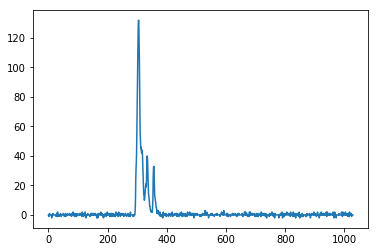

In [27]:
idx = 11923
plt.plot(x[1200000+idx][0].numpy())
idx_n = np.where(y[1200000+idx].numpy()>0)[0]
print('该事例的脉冲击中时间为', idx_n)
print('该事例的击中光子数为', y[1200000+idx][idx_n])
idx_p = np.where(predict[idx]>0.15)[0]
print('该事例的预测脉冲击中时间为', idx_p)
print('该事例的预测击中光子数为', predict[idx][idx_p])
w1 = predict[idx][idx_p]
w_dist = scipy.stats.wasserstein_distance(idx_n, idx_p, v_weights=w1)
print('该事例的w距离为', w_dist)

计算验证集波形的w距离， 并将其存入数组w_dists

In [31]:
w_dists = np.zeros(nevt)

for i in range(nevt):
    if i%10000==0: print(i)
    idx_n = np.where(y[1200000+i].numpy()>0)[0]
    if(len(idx_n)==0):
        print(i)
        w_dists[i] = 0
        continue
    idx_p = np.where(predict[i]>0.1)[0]
    w1 = predict[i][idx_p]
    if(len(w1)==0):
        idx_p = [295]
        w1 = [1]
    w_dists[i] = scipy.stats.wasserstein_distance(idx_n, idx_p, v_weights=w1)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


计算w距离的均值， 并作出w距离的分布图。

w距离的均值为1.730436


Text(0.5,1,'w dists')

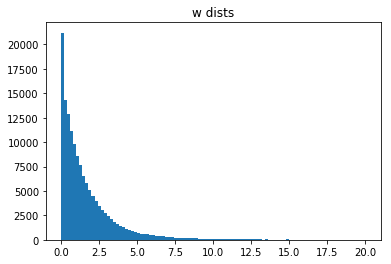

In [32]:
w_min = w_dists[:].mean()
print('w距离的均值为%f'%w_min)

plt.hist(w_dists, bins=100, range=(0,20))
plt.title('w dists')

展示出一些w距离特别大的事例的编号

In [33]:
np.where(w_dists>20)[0][:20]

array([  957,  1841,  2236,  3091,  3475,  4615,  4654,  6934,  8187,
        8192,  9111, 11538, 11547, 17399, 18351, 19019, 19157, 19457,
       19511, 19952], dtype=int64)

展示出其中一个w距离较大的通道， 并打印出真实击中时间和预测击中时间以进行比较。结果显示当几个击中时间相差较大时即使预测时间完全正确小数与整数的偏差也可能造成大的w距离。 此事例的w距离为24.38。

[287 297 298 712]
tensor([1., 1., 2., 1.])
[287 297 298 712]
[1.378  0.7173 2.13   0.9863]
25.4015456674473


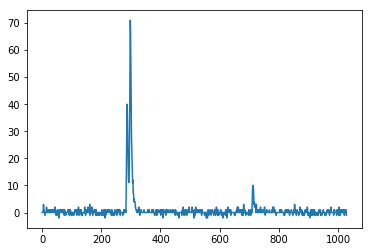

In [48]:
idx = 1841
plt.plot(x[1200000+idx][0].numpy())
idx_n = np.where(y[1200000+idx].numpy()>0)[0]
print(idx_n)
print(y[1200000+idx][idx_n])
idx_p = np.where(predict[idx]>0.15)[0]
print(idx_p)
print(predict[idx][idx_p])
w1 = predict[idx][idx_p]
w_dist = scipy.stats.wasserstein_distance(idx_n, idx_p, v_weights=w1)
print(w_dist)

将所有大于0.8的值四舍五入后重新计算w距离

In [49]:
w_dists_new = np.zeros(nevt)

for i in range(nevt):
    if i%10000==0: print(i)
    idx_n = np.where(y[1200000+i].numpy()>0)[0]
    if(len(idx_n)==0):
        print(i)
        w_dists_new[i] = 0
        continue
    idx_p = np.where(predict[i]>0.1)[0]
    idx_p2 = np.where(predict[i]>0.8)[0]
    predict[i][idx_p2] = np.round(predict[i][idx_p2])
    w1 = predict[i][idx_p]
    if(len(w1)==0):
        idx_p = [295]
        w1 = [1]
    w_dists_new[i] = scipy.stats.wasserstein_distance(idx_n, idx_p, v_weights=w1)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


w距离的表现有所提升，但不大

w距离的均值为1.604806


Text(0.5,1,'w dists')

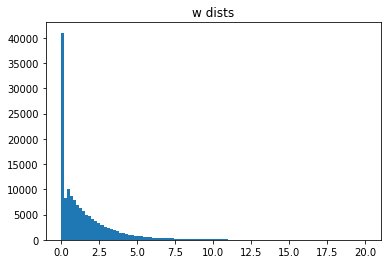

In [50]:
w_min = w_dists_new[:].mean()
print('w距离的均值为%f'%w_min)

plt.hist(w_dists_new, bins=100, range=(0,20))
plt.title('w dists')